## Importações e leitura

In [1]:
!pip install spacy
!python -m spacy download pt_core_news_sm

import numpy as np
import pandas as pd

import json
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

import pt_core_news_sm

from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt

[+] Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\masin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\masin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df_dataset = pd.read_csv('20052021.csv')

display(df_dataset.shape)
display(df_dataset.head())

(738, 7)

,_id,created_at,tweet_content,keyword,user_location,entities,classification
0,ObjectId(6091f3547ef2d107a44055cc),2021-05-04 12:30:48,mds nubank nunca libera mais limite pra mim,['Nubank'],Goiânia,"{'hashtags': [], 'urls': [], 'user_mentions': ...","[{""classification"":false,""created_at"":""2021-05..."
1,ObjectId(6091f3547ef2d107a44055cd),2021-05-04 12:31:09,mais viciado que a bateria do meu celular só e...,['Coca-cola'],Balneário Camboriú,"{'hashtags': [], 'urls': [], 'user_mentions': ...","[{""classification"":false,""created_at"":""2021-05..."
2,ObjectId(6091f3547ef2d107a44055ce),2021-05-04 12:31:27,toda vez que vejo Nubank nos tt vou lá conferi...,['Nubank'],None,"{'hashtags': [], 'urls': [], 'user_mentions': ...","[{""classification"":false,""created_at"":""2021-05..."
3,ObjectId(6091f3547ef2d107a44055cf),2021-05-04 12:31:25,Pedi 10k de limite pra Nubank serasi?,['Nubank'],"Rio de Janeiro, Brasil","{'hashtags': [], 'urls': [], 'user_mentions': ...","[{""classification"":true,""created_at"":""2021-05-..."
4,ObjectId(6091f3547ef2d107a44055d0),2021-05-04 12:31:20,@kayofeer @nubank Aconteceu isso c a minha mãe...,['Nubank'],"Macaé, Brasil","{'hashtags': [], 'urls': [], 'user_mentions': ...","[{""classification"":false,""created_at"":""2021-05..."


## Engenharia de atributos

In [3]:
# Verificação de valores nulos

display(df_dataset.isna().sum())

_id                0
created_at         0
tweet_content      0
keyword            0
user_location      1
entities           0
classification    72
dtype: int64

**Como existem 72 ocasiões cujos campos de classificação estão vazios, será feita a remoção desses registros**

In [4]:
# Remoção de atributos irrelevantes para a análise

df_removed = df_dataset.drop(['_id', 'created_at', 'entities'], axis=1)

display(df_removed.shape)
display(df_removed.head(n=2))

(738, 4)

,tweet_content,keyword,user_location,classification
0,mds nubank nunca libera mais limite pra mim,['Nubank'],Goiânia,"[{""classification"":false,""created_at"":""2021-05..."
1,mais viciado que a bateria do meu celular só e...,['Coca-cola'],Balneário Camboriú,"[{""classification"":false,""created_at"":""2021-05..."


In [5]:
# Remoção de amostras onde o campo de classifificação é vazio

df_dropna = df_removed.dropna(subset = ['classification'])

display(df_removed.shape)
display(df_dropna.shape)

(738, 4)

(666, 4)

## Análise de keywords

In [6]:
# Valores

display(Counter(df_dataset["keyword"]))

Counter({"['Nubank']": 236,
         "['Coca-cola']": 16,
         "['Nike']": 201,
         "['Xiaomi']": 26,
         "['Coca cola']": 64,
         "['SHEIN']": 169,
         '[]': 16,
         "['Boticário']": 8,
         "['Nike', 'SHEIN']": 1,
         "['Nike', 'Xiaomi']": 1})

Counter({"['Nubank']": 221,
         "['Coca-cola']": 71,
         "['Nike']": 177,
         "['Xiaomi']": 23,
         "['SHEIN']": 150,
         '[]': 15,
         "['Boticário']": 7,
         "['Nike', 'SHEIN']": 1,
         "['Nike', 'Xiaomi']": 1})

<AxesSubplot:xlabel='count', ylabel='keyword'>

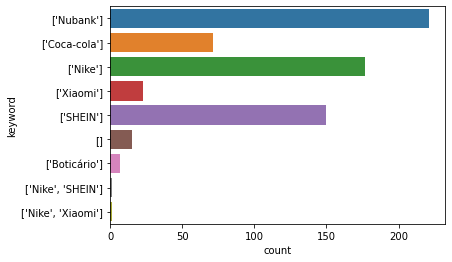

In [7]:
# Normalização de "Coca-Cola"

search = "Coca cola"
replacement = "Coca-cola"

df_normalized = df_dropna.copy()
df_normalized["keyword"] = df_dropna["keyword"].apply(
    lambda keywords: keywords.lower().replace(search.lower(), replacement) if search.lower() in keywords.lower() else keywords)


# Valores

display(Counter(df_normalized["keyword"]))


# Histograma

sns.countplot(y="keyword", data=df_normalized)

## Tratamento da classificação

Como são 3 classificações para cada registro, ganha a classificação da **maioria** dos registros

Exemplos:

- True, True, False => True
- False, True, False => False

In [8]:
# Criação de um campo de resultado de classificação com a maior ocorrência entre as classificaçações

pd.options.mode.chained_assignment = None

def reducer(input_dict):
  return input_dict['classification']

def get_classification(input_list):
  return Counter(list(map(reducer, json.loads(input_list)))).most_common()[0][0]

# df_classified = df_normalized.apply(lambda item: get_classification(item[2]), axis=1)

df_normalized['classified'] = df_normalized['classification'].map(lambda classification_list: get_classification(classification_list))

df_classified = df_normalized.drop(['classification'], axis=1)

In [9]:
# Transformação numérica da classificação

df_classified['classified'][df_classified['classified'] == True] = 1
df_classified['classified'][df_classified['classified'] == False] = 0

display(df_classified.head())

,tweet_content,keyword,user_location,classified
0,mds nubank nunca libera mais limite pra mim,['Nubank'],Goiânia,0.0
1,mais viciado que a bateria do meu celular só e...,['Coca-cola'],Balneário Camboriú,1.0
2,toda vez que vejo Nubank nos tt vou lá conferi...,['Nubank'],None,0.0
3,Pedi 10k de limite pra Nubank serasi?,['Nubank'],"Rio de Janeiro, Brasil",1.0
4,@kayofeer @nubank Aconteceu isso c a minha mãe...,['Nubank'],"Macaé, Brasil",1.0


## Tokenização e remoção das stopwords

In [10]:
nlp = pt_core_news_sm.load()

In [11]:
def limpar_texto(texto):
    '''
    Função para converter todas as letras para sua forma minúscula, selecionar apenas as letras,
    remover stopwords e lematizar o texto.  
    '''
    
    # Removendo as marcas para que elas não apareçam nas wordclouds, pois consomem muito espaço
    marcas = ['nubank', 'shein', 'nike', 'coca', 'cola', 'xiaomi', 'adidas', 'boticário',
             'puma']
    
    # Stopwords que tiveram que ser adicionadas manualmente
    custom_stops = ['pra', 'q', '_', 'vai', 'vc', 'tá', 'gente', 'tô', 'to', 'aqui', 'tava',
                   'ta', 'tá', 'hoje', 'hj', '-', 'eh', 'so', 'n', 'c', 'mó', 'modalmais',
                   'ouotison', 'tbm', 'tão', 'aí', 'nu', 'p', 'mano', 'nois', 'pro', 'umas',
                   'uns', 'então', 'x', 'ne', 'kkkkkkkk', 'kkk', 'vou', 'vcs', 'kkkkk', 
                    'nicole', 'kkkk', 'vivianlana', 'gabriel_geno', 'ai', 'tou', 'vir', 'ja', 
                    'já', 'pq', 'amg', 'ti', 'onde', 'meio', 'outro', 'amigo', 'sep_bella',
                   '_gabriel_geno_', 'manu', 'ir', 'tt', 'mim', 'psg', 'sep_bella_', 's',
                   'tudo', 'todo', 'todos', 'rodrigobuenotv', 'limite', 'aumentar', 'querer', 
                    'fazer', 'querer', 'comprar', 'ser', 'nathalia', 'mt', 'en', 'd']
    
    # Palavras identificadas como indiferentes após teste das wordclouds
    palavras_iguais = ['limite', 'aumentar', 'queria', 'faz', 'quero', 'comprar', 'ser']
    
    # Convertendo todas as letras para minúsculas
    minusculas = texto.lower()
    letras = re.findall(r'\b[A-zÀ-úü]+\b', minusculas) 
    
    # Removendo as stopwords
    stops = set(stopwords.words('portuguese')) 
    palavras_sem_stopwords = [w for w in letras if 
                            w not in stops and 
                            w not in marcas and 
                            w not in custom_stops and
                            w not in palavras_iguais]
    palavras_importantes = " ".join(palavras_sem_stopwords)

    # Lemmatizando o texto
    spc_letras = nlp(palavras_importantes)
    lemmas = [token.lemma_ if token.pos_ == 'VERB' else str(token) for token in spc_letras]
    texto_limpo = " ".join(lemmas)
    
    return texto_limpo

### Funções de plotagem de alguns gráficos e wordclouds

In [12]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def plot_cloud(wordcloud):
    plt.figure(figsize=(40, 30))
    plt.imshow(wordcloud) 
    plt.axis("off")
    
def plot_tweet_avg_lenght(df):
    return df['tweet_content'].str.len().hist()

def plot_word_number_histogram(text):
    text.str.split().\
        map(lambda x: len(x)).\
        hist()
    
def plot_average_word_lenght(text):
    text.str.split().\
        apply(lambda x : [len(i) for i in x]). \
        map(lambda x: np.mean(x)).hist()

In [13]:
df_clean_text = df_classified.copy()
df_clean_text.head()

,tweet_content,keyword,user_location,classified
0,mds nubank nunca libera mais limite pra mim,['Nubank'],Goiânia,0.0
1,mais viciado que a bateria do meu celular só e...,['Coca-cola'],Balneário Camboriú,1.0
2,toda vez que vejo Nubank nos tt vou lá conferi...,['Nubank'],None,0.0
3,Pedi 10k de limite pra Nubank serasi?,['Nubank'],"Rio de Janeiro, Brasil",1.0
4,@kayofeer @nubank Aconteceu isso c a minha mãe...,['Nubank'],"Macaé, Brasil",1.0


In [14]:
df_clean_text['tweet_content'] = df_classified['tweet_content'].apply(limpar_texto)

**Separando os datasets em positivo e negativo para formar as wordclouds**

In [15]:
df_positive = df_clean_text[df_clean_text['classified'] == 1.0]
df_positive.head()

,tweet_content,keyword,user_location,classified
1,viciar bateria celular,['Coca-cola'],Balneário Camboriú,1.0
3,pedir serasi,['Nubank'],"Rio de Janeiro, Brasil",1.0
4,kayofeer acontecer mãe quase ano nada ainda,['Nubank'],"Macaé, Brasil",1.0
5,escolher aumentar reais uau revolucionário kkk...,['Nubank'],"Ribeirão Preto, Brasil",1.0
6,achar preju tempos algo inesperado ahhh inocente,['Nubank'],"São Paulo, Brasil",1.0


In [16]:
df_negative = df_clean_text[df_clean_text['classified'] == 0.0]
df_negative.head()

,tweet_content,keyword,user_location,classified
0,mds nunca liberar,['Nubank'],Goiânia,0.0
2,toda vez vejo lá conferir saldo certo juro tra...,['Nubank'],None,0.0
7,rodrigolps _ caso observo aumentar juros dívida,['Nubank'],🏳️‍🌈,0.0
8,msswx processo nele,['Nubank'],Macaé,0.0
12,gastar cueca calvin klein,['Nike'],Hell not Helsinki,0.0


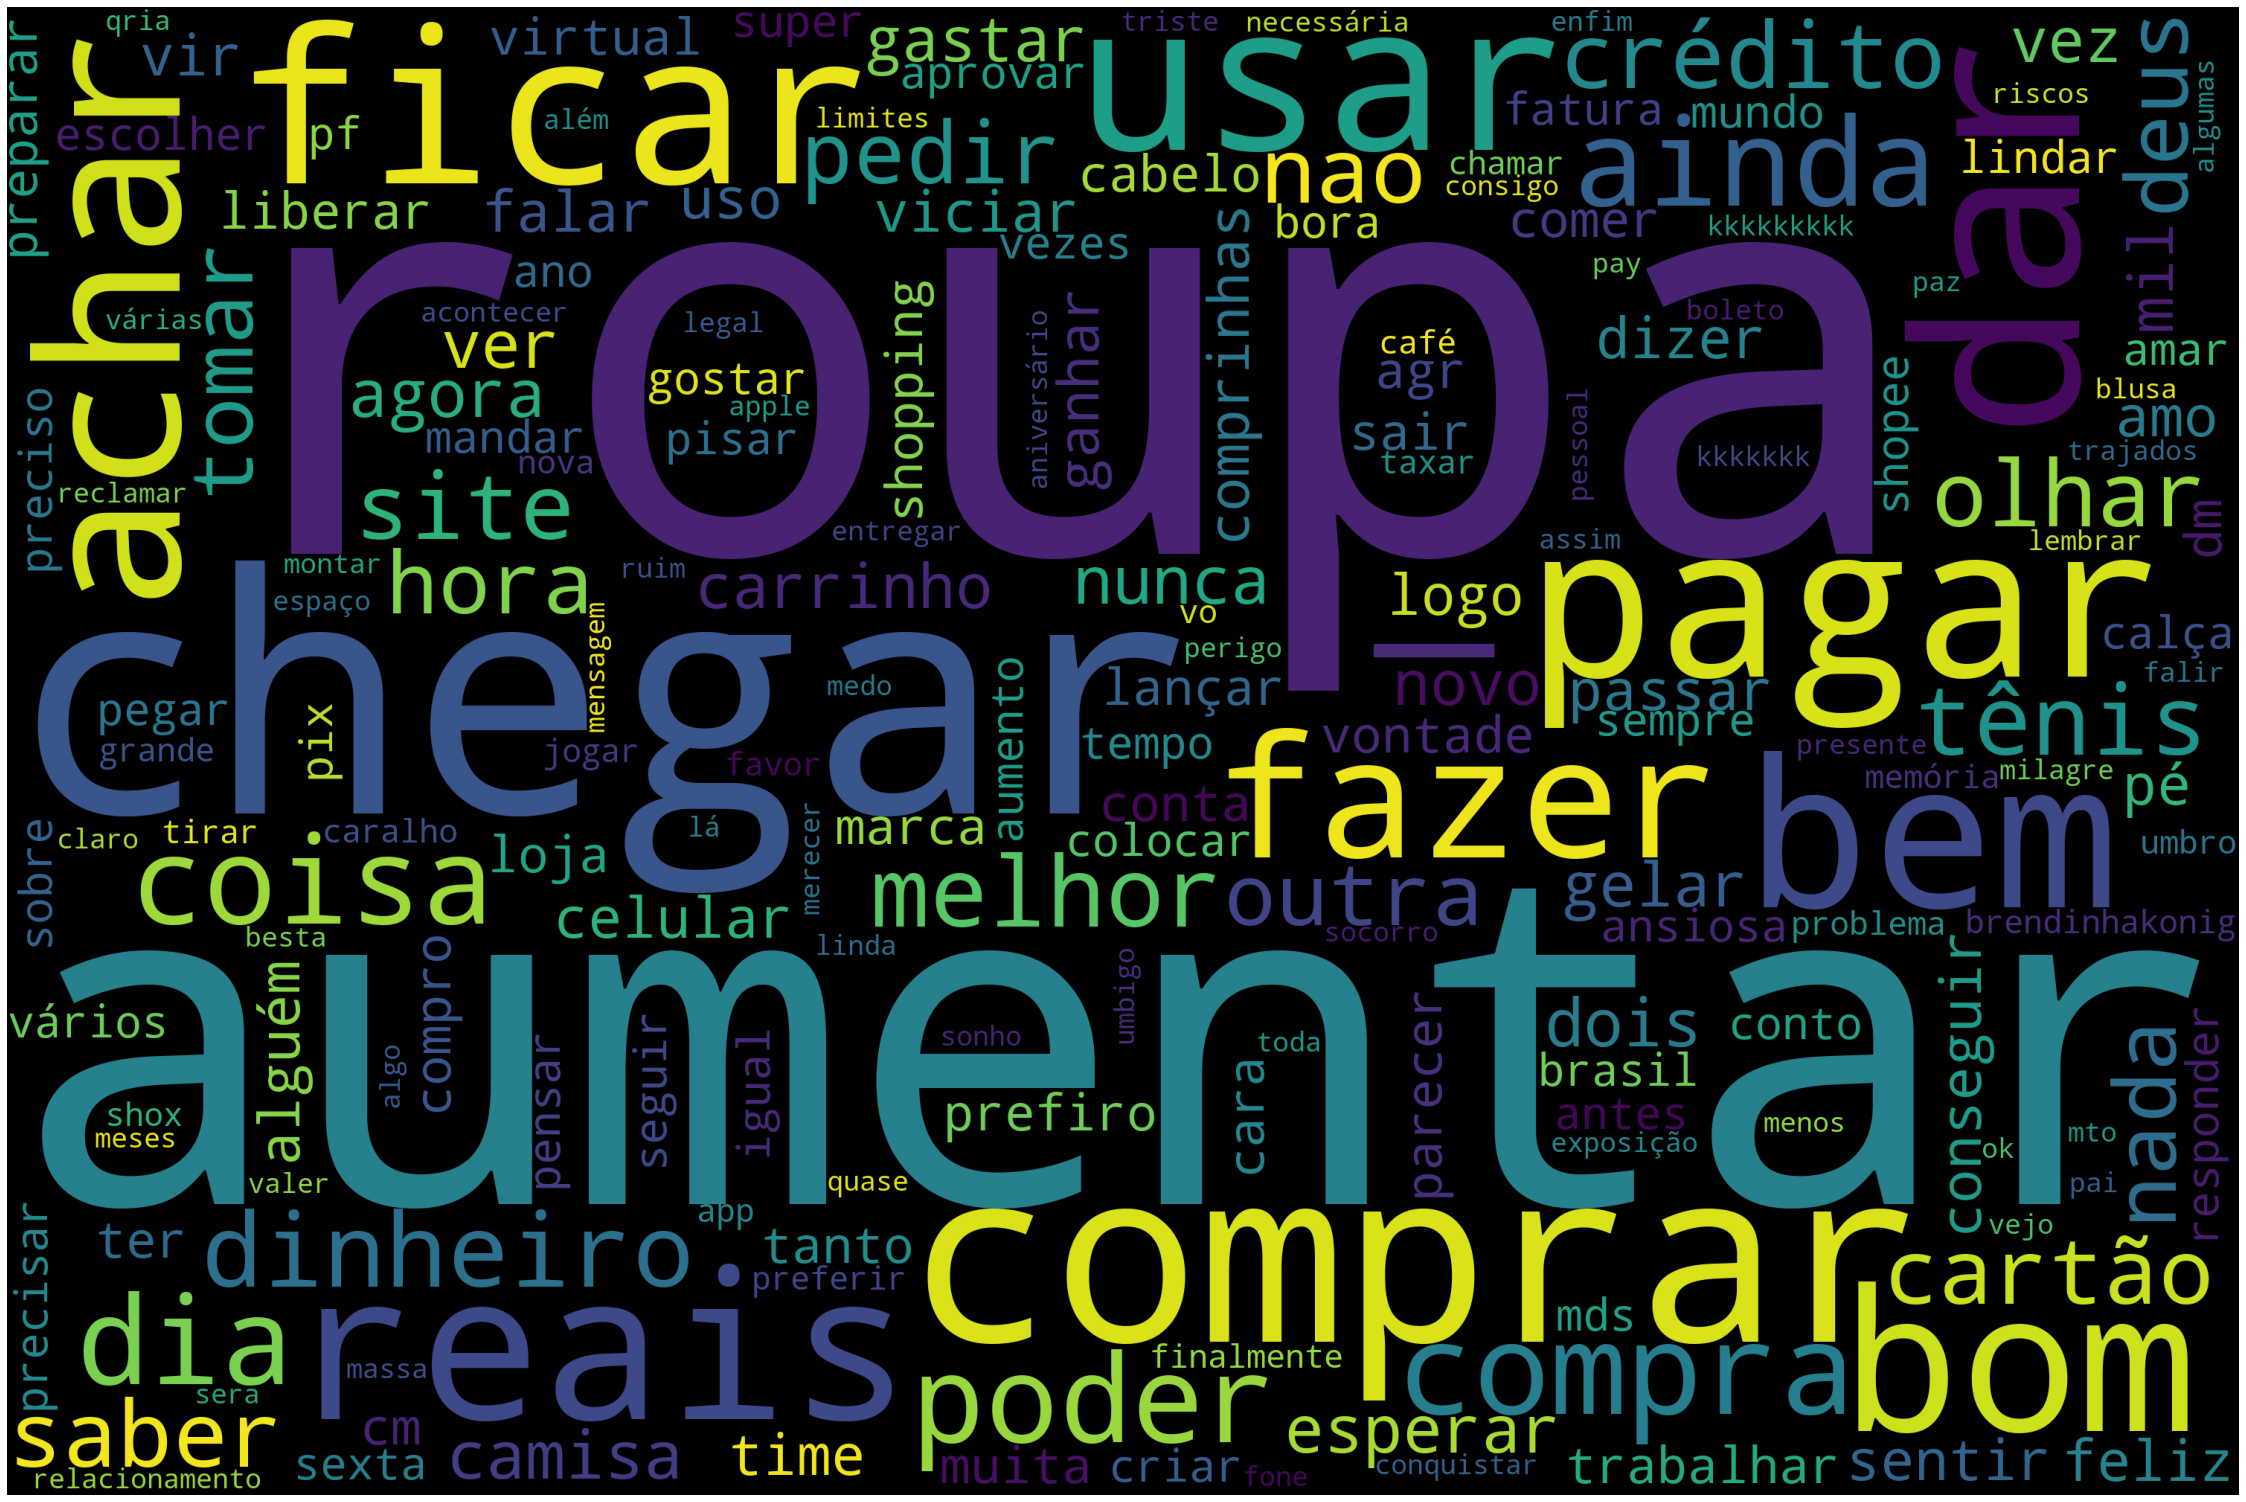

In [17]:
wordcloud_pos = WordCloud(width = 3000, height = 2000, random_state=1,
                      collocations=False).generate(' '.join(df_positive['tweet_content']))

plot_cloud(wordcloud_pos)
wordcloud_pos.to_file("img/pos_wordcloud.png")

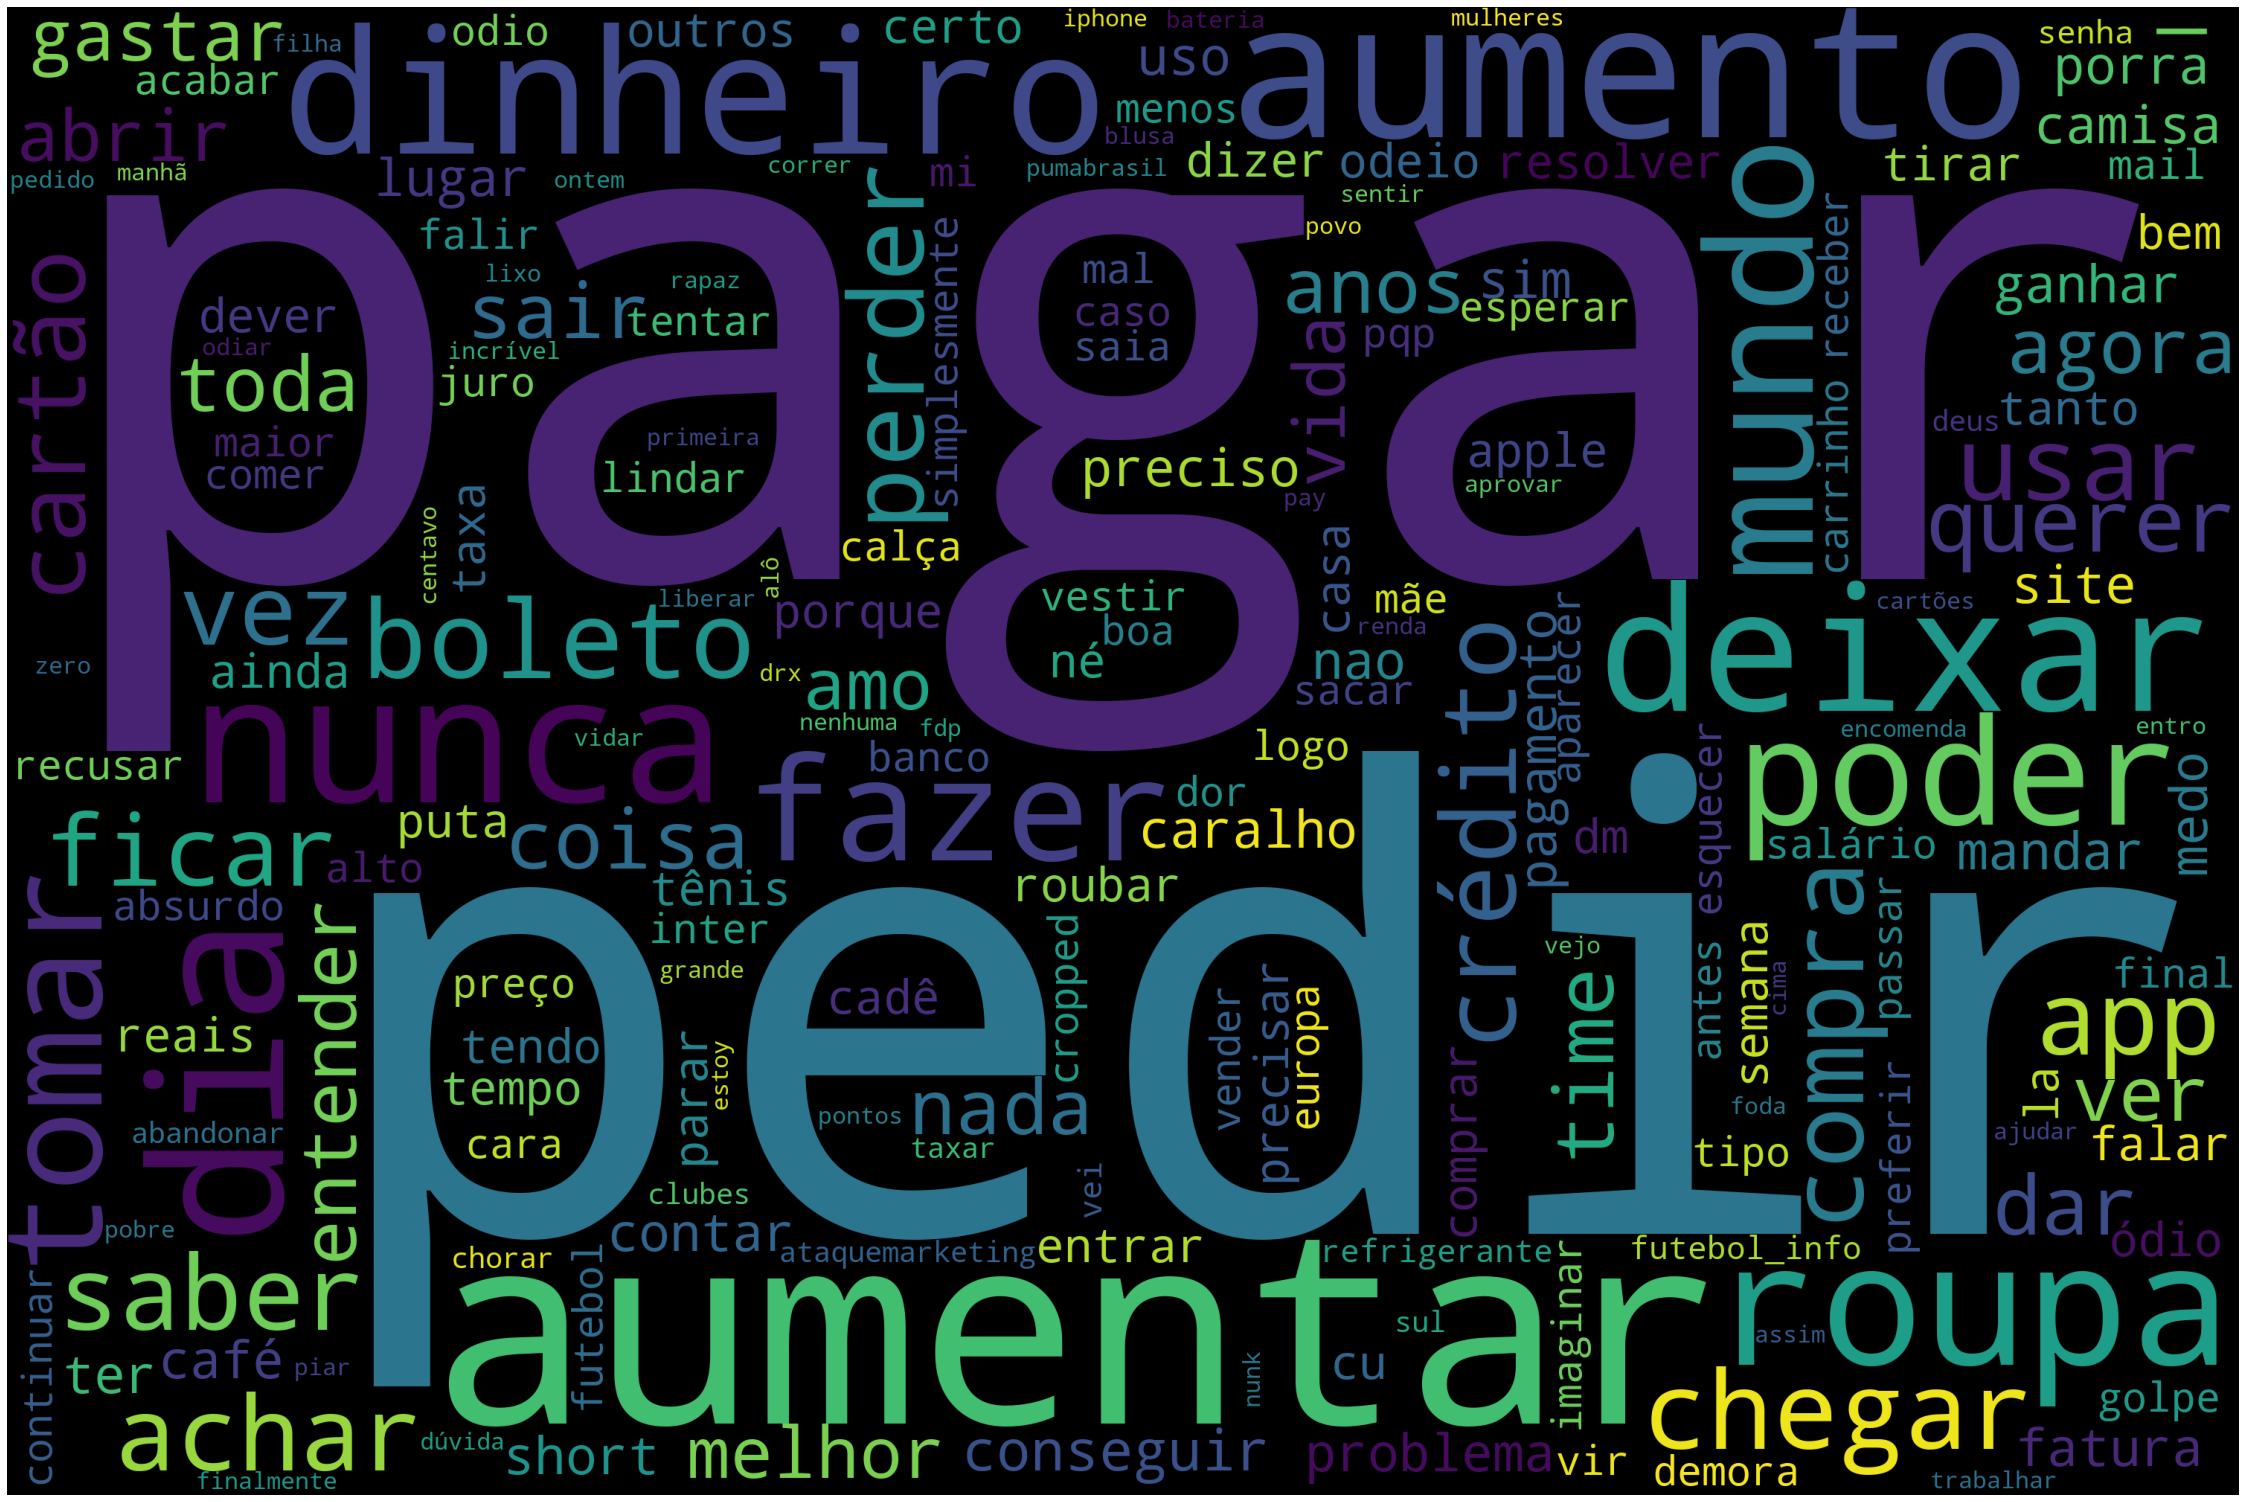

In [18]:
wordcloud_neg = WordCloud(width = 3000, height = 2000, random_state=1,
                      collocations=False).generate(' '.join(df_negative['tweet_content']))

plot_cloud(wordcloud_neg)
wordcloud_neg.to_file("img/neg_wordcloud.png")

**Salvando os dataframes em arquivos csv para serem utilizados depois**

In [19]:
df_clean_text.to_csv("files/clean_text.csv")
df_positive.to_csv("files/positive.csv")
df_negative.to_csv("files/negative.csv")

**Plotando sentimentos por palavra-chave**

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


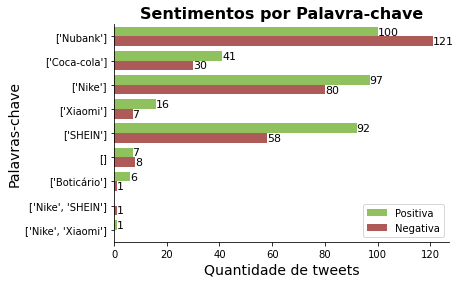

In [20]:
# Dataframe especialmente para o plot

order = ["Positiva", "Negativa"]

df_countplot = df_clean_text.copy()
df_countplot = df_countplot.rename({"classified": "Classificação"}, axis=1)
df_countplot["Classificação"][df_countplot["Classificação"] == 1.0] = order[0]
df_countplot["Classificação"][df_countplot["Classificação"] == 0.0] = order[1]


# Plot

colors = ["#8FD14F", "#BC4C4B"]
sns.set_palette(sns.color_palette(colors))
plot_output = sns.countplot(y="keyword",
                            data=df_countplot,
                            hue="Classificação",
                            hue_order=order)

plot_output.legend(loc="lower right")

plot_output.set_title("Sentimentos por Palavra-chave", fontsize=16, fontweight="bold")
plot_output.set_xlabel("Quantidade de tweets", fontsize=14)
plot_output.set_ylabel("Palavras-chave", fontsize=14)

plot_output.spines["top"].set_visible(False)
plot_output.spines["right"].set_visible(False)

for rect in plot_output.patches:
    plot_output.text(rect.get_width(),
                     rect.get_y(),
                     str(rect.get_width())[:-2],
                     horizontalalignment="left",
                     verticalalignment="top",
                     fontsize=11)

plot_output.figure.savefig("img/keyword_analysis_labeled.png", bbox_inches="tight")